# gwexpy Plotting Introduction

このノートブックでは、`gwexpy` の強化されたプロット機能を紹介します。
`TimeSeriesMatrix` や `FrequencySeriesMatrix` などの行列データ構造、および `SpectrogramList` などのコレクションに対する、「いい感じ」のデフォルト設定（figsize自動調整、対数軸、レイアウト、軸ラベル）についてデモを行います。


In [1]:
import numpy as np
from astropy import units as u
from gwexpy.timeseries import TimeSeriesMatrix, TimeSeriesList
from gwexpy.frequencyseries import FrequencySeries, FrequencySeriesList, FrequencySeriesMatrix
from gwexpy.spectrogram import Spectrogram, SpectrogramList
from gwexpy.plot import Plot
import matplotlib.pyplot as plt

# ランダムシードの固定
np.random.seed(42)


## 1. TimeSeriesMatrix Plotting

`TimeSeriesMatrix` は (Row, Col, Time) の3次元構造を持つ時系列データを管理します。
`.plot()` を呼び出すと、以下の最適化が行われます：
- **軸ラベル**: `determine_xlabel` により "Time [s]" や "Time [s] from ..." が自動設定されます。
- **Auto-GPS**: 時間軸の場合、デフォルトで `auto-gps` スケールが適用され、GPS時刻（大きなオフセット）が適切に処理されます。
- **レイアウト**: 行・列の構造に合わせて `figsize` が自動調整されます。


/home/washimi/mambaforge/lib/python3.10/site-packages/gwpy/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


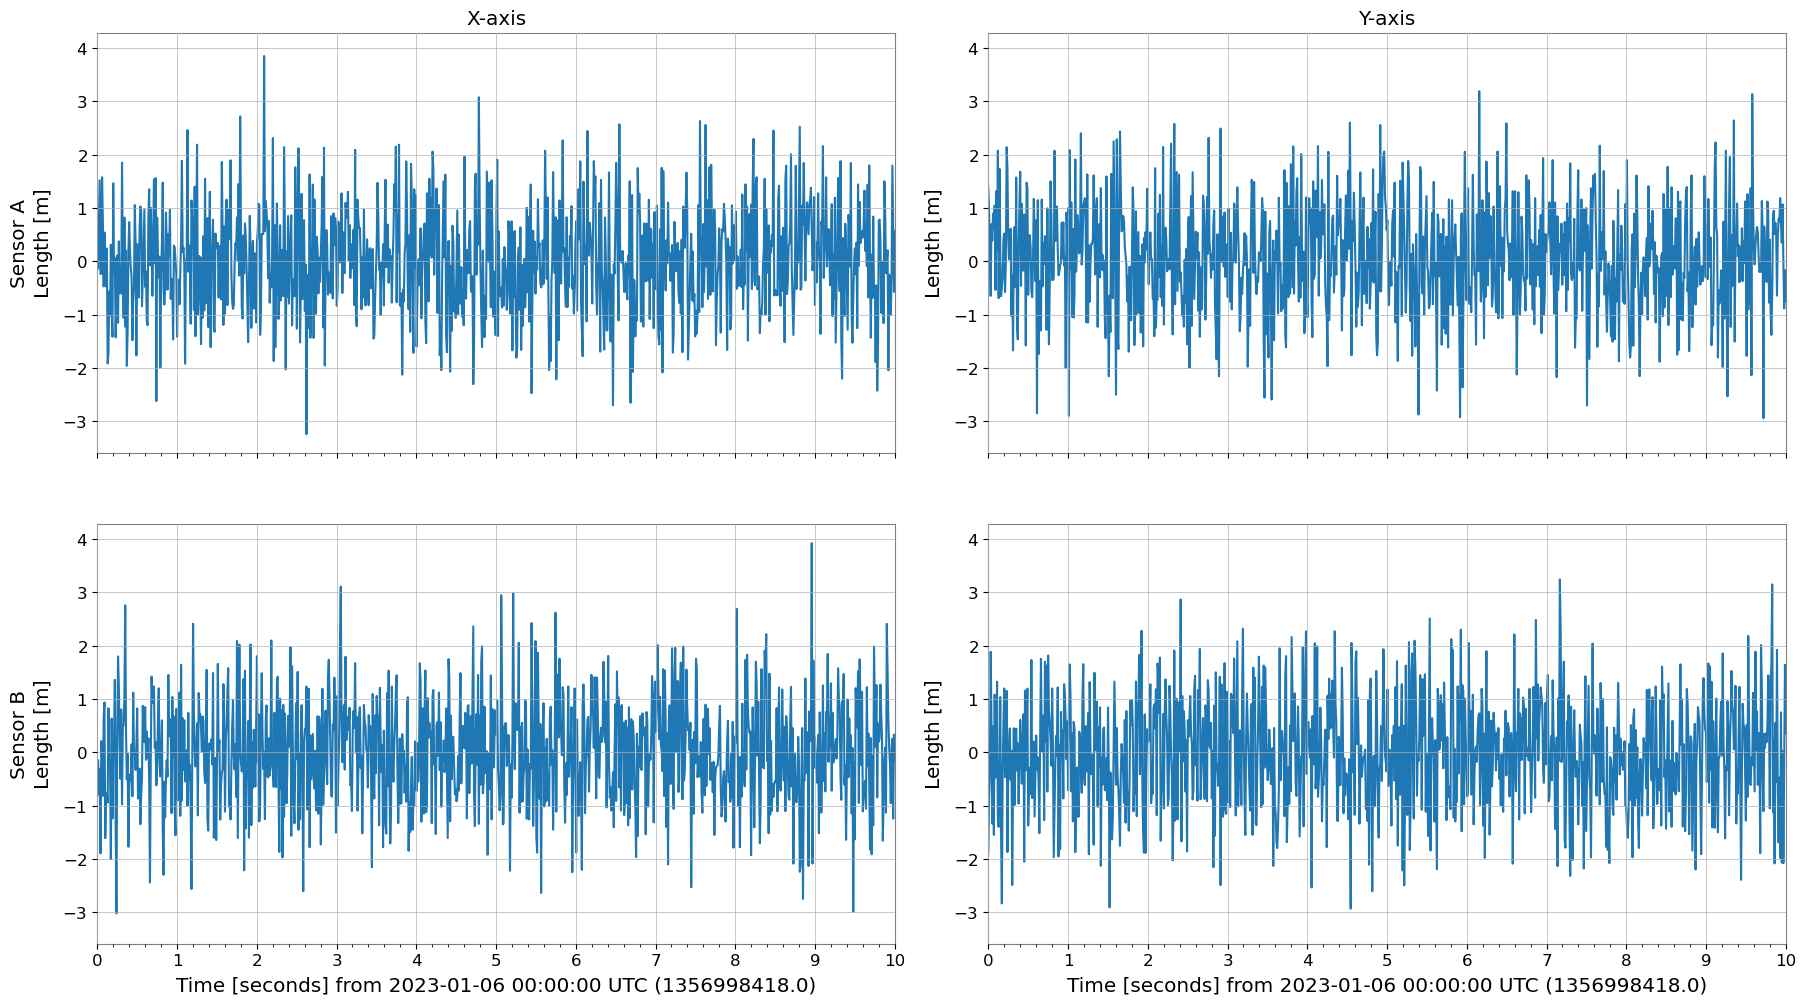

In [2]:
# 2x2 の TimeSeriesMatrix を作成
# GPS時刻 (例: 1356998418 = 2023-01-01 00:00:00 UTC) からの10秒間
t0 = 1356998418.0
times = t0 + np.linspace(0, 10, 1000)
data = np.random.randn(2, 2, 1000)
# 行: Sensor A, B / 列: Axis X, Y
tsm = TimeSeriesMatrix(data, times=times, unit='m', name='Velocity',
                       rows=['Sensor A', 'Sensor B'],
                       cols=['X-axis', 'Y-axis'])

# プロット
# auto-gps により、横軸ラベルに "Time [s] from 1356998418..." と表示されることを確認してください。
plot = tsm.plot()
plot.show()


## 2. FrequencySeriesMatrix Plotting

`FrequencySeriesMatrix` は (Row, Col, Frequency) の3次元構造を持つ周波数データを管理します。
一般的なスペクトル解析の結果などを保持します。
`.plot()` の特徴：
- **対数軸**: データサイズ等の条件に応じて、X軸（周波数）やY軸（振幅）が自動的に対数スケールになります。
- **軸ラベル**: "Frequency [Hz]" や "[unit]" が自動設定されます。


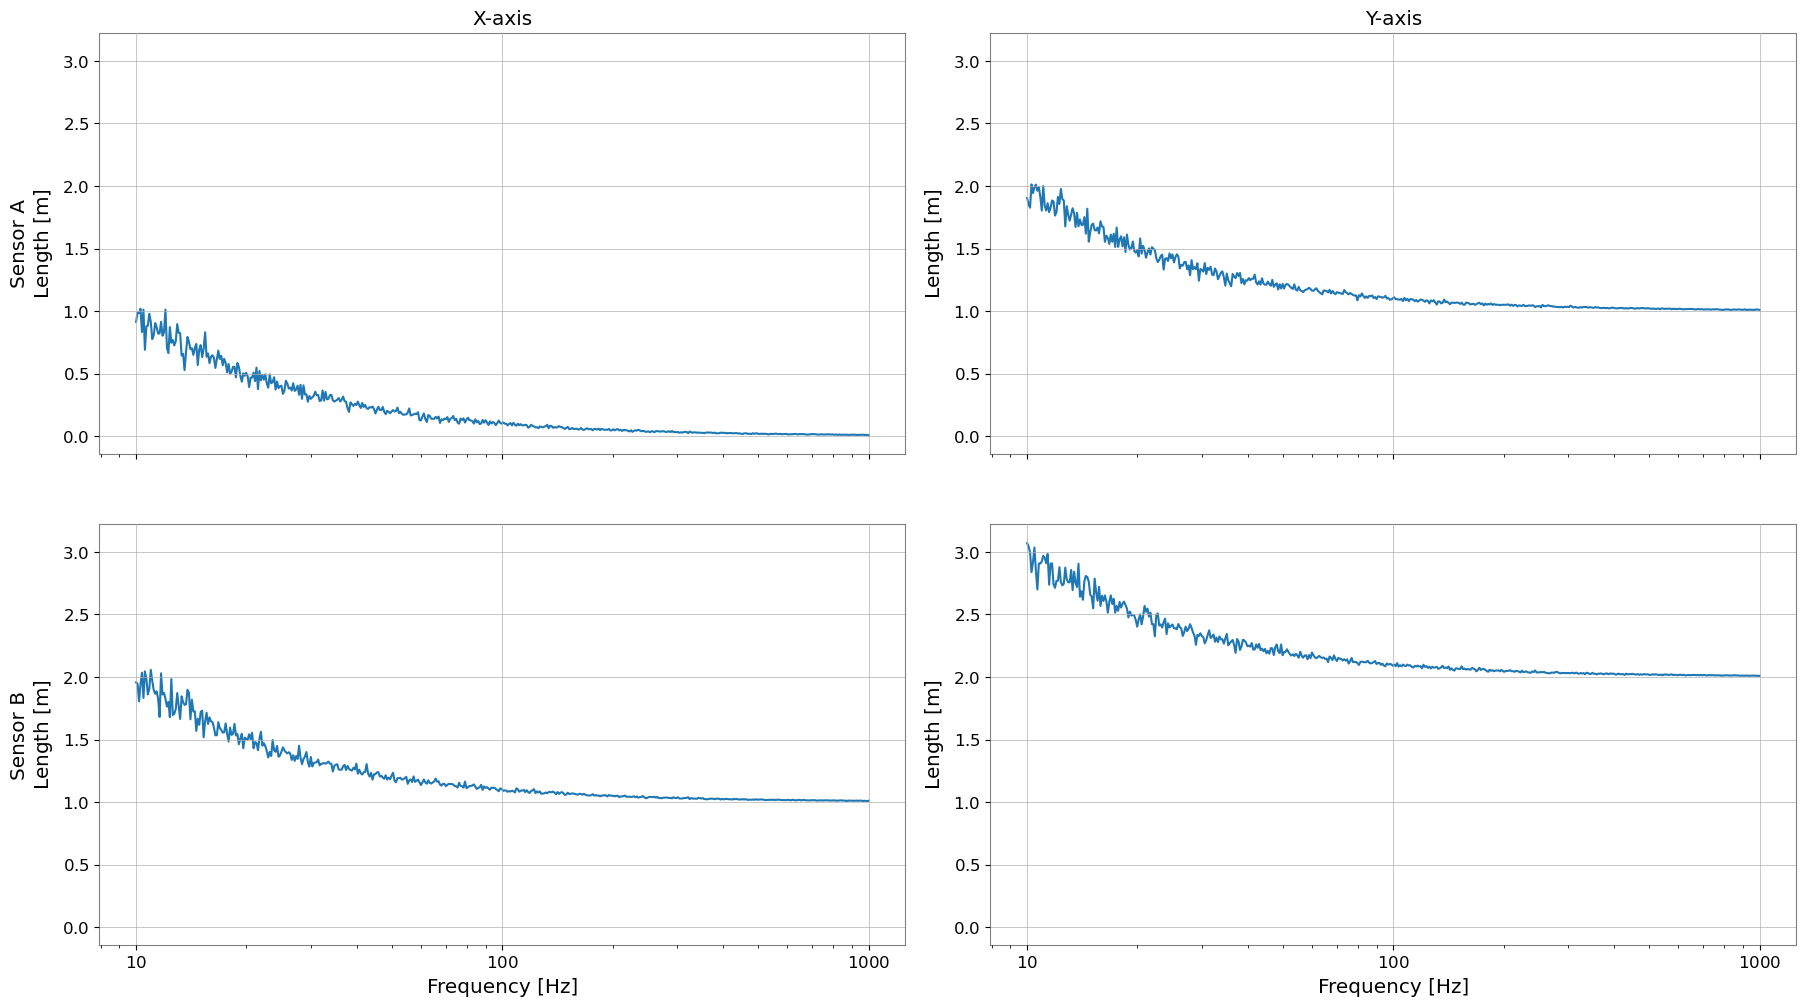

In [3]:
# FrequencySeriesMatrix の作成
# 10Hz から 1kHz
f = np.logspace(1, 3, 500) 
# 1/f ノイズのようなデータを生成
data = np.zeros((2, 2, 500))
for i in range(2):
    for j in range(2):
        data[i, j, :] = 10 / f * (1 + 0.1 * np.random.randn(500)) + (i+j)

# unit='m' (Amplitude Spectral Density と仮定すると m/sqrt(Hz) ですが、ここでは単純化)
fsm = FrequencySeriesMatrix(data, frequencies=f, unit='m', name='Displacement',
                            rows=['Sensor A', 'Sensor B'], 
                            cols=['X-axis', 'Y-axis'])

# プロット
# 自動的に log-log プロットになることを確認してください
plot = fsm.plot()
plot.show()


## 3. FrequencySeriesList Plotting (参考)

`FrequencySeriesList` (または Dict) は、グリッド構造を持たない単純なリストです。
これも同様にプロット可能です。


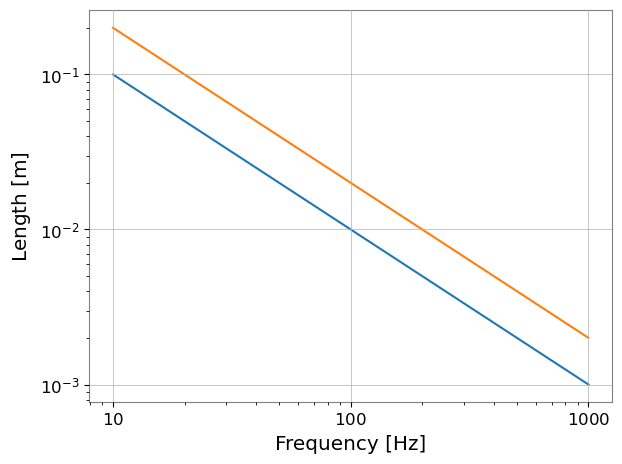

In [4]:
# FrequencySeriesList の作成
fs1 = FrequencySeries(1/f, frequencies=f, unit=u.m, name='Series 1')
fs2 = FrequencySeries(2/f, frequencies=f, unit=u.m, name='Series 2')

fs_list = FrequencySeriesList([fs1, fs2])

plot = fs_list.plot()
plot.show()


## 4. SpectrogramList Plotting

`SpectrogramList` のプロットは、デフォルトで `geometry=(N, 1)` の縦並びレイアウト、対数カラーバーなどが適用されます。
スペクトログラムも時間軸を持つため、GPS時刻を与えると `auto-gps` が機能します。


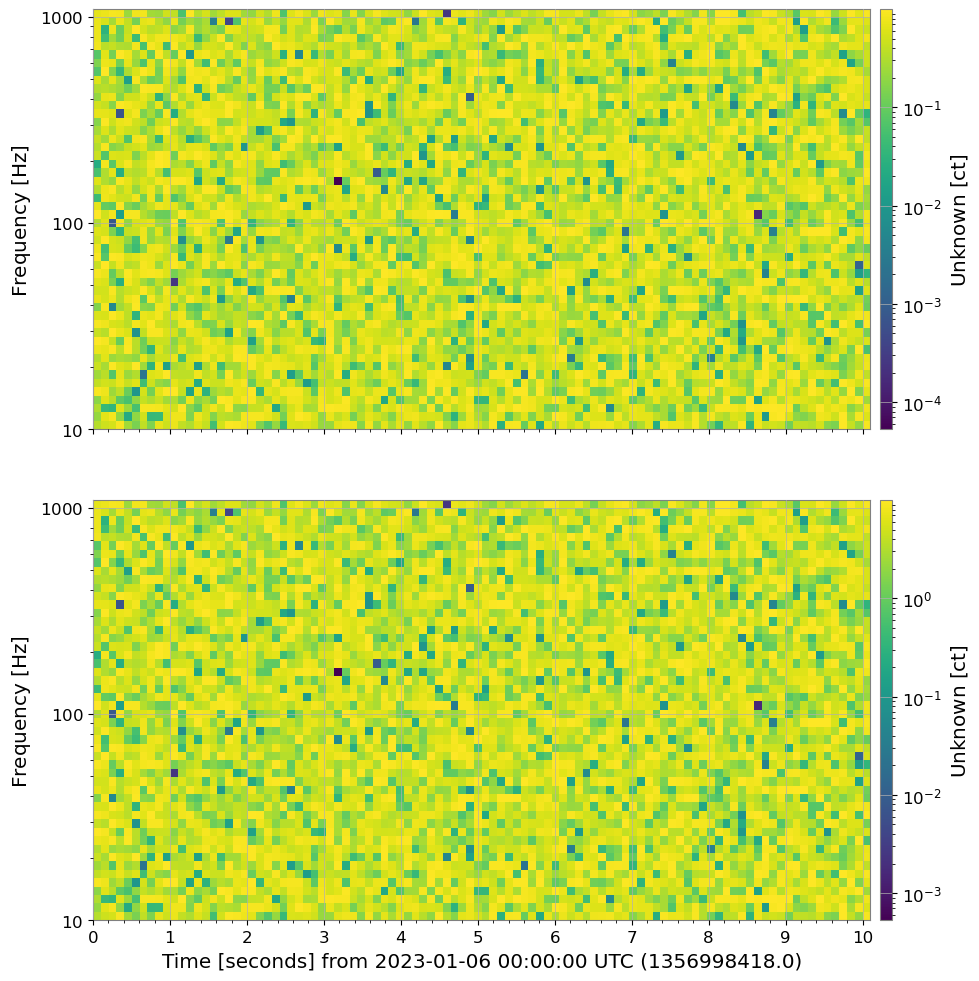

In [5]:
# Spectrogram の作成
# TimeSeriesMatrix と同じ GPS 時刻を使用
t = t0 + np.linspace(0, 10, 100)
 # 10Hz - 1000Hz
spec_data = np.random.rand(100, 50)

spec1 = Spectrogram(spec_data, times=t, frequencies=np.logspace(1, 3, 50), unit=u.count, name='Spec 1')
spec2 = Spectrogram(spec_data*10, times=t, frequencies=np.logspace(1, 3, 50), unit=u.count, name='Spec 2')

spec_list = SpectrogramList([spec1, spec2])

plot = spec_list.plot()
plot.show()


## 4. Adaptive Plotting Optimization (Decimation)

大量のデータを持つ `TimeSeries` をプロットする際、描画パフォーマンスを維持するために自動的に間引き（Min-Max Decimation）を適用します。
- **自動適用**: デフォルトではサンプル数が 50,000 を超える場合に発動します。
- **ピーク維持**: Min-Max アルゴリズムにより、波形のエンベロープ（最大・最小）を保持したままデータ点を削減（デフォルト 約10,000点）します。
- **カスタマイズ**: `decimate_threshold` や `decimate_points` 引数で制御可能です。

Original samples: 100000000
Plotted points: 10000


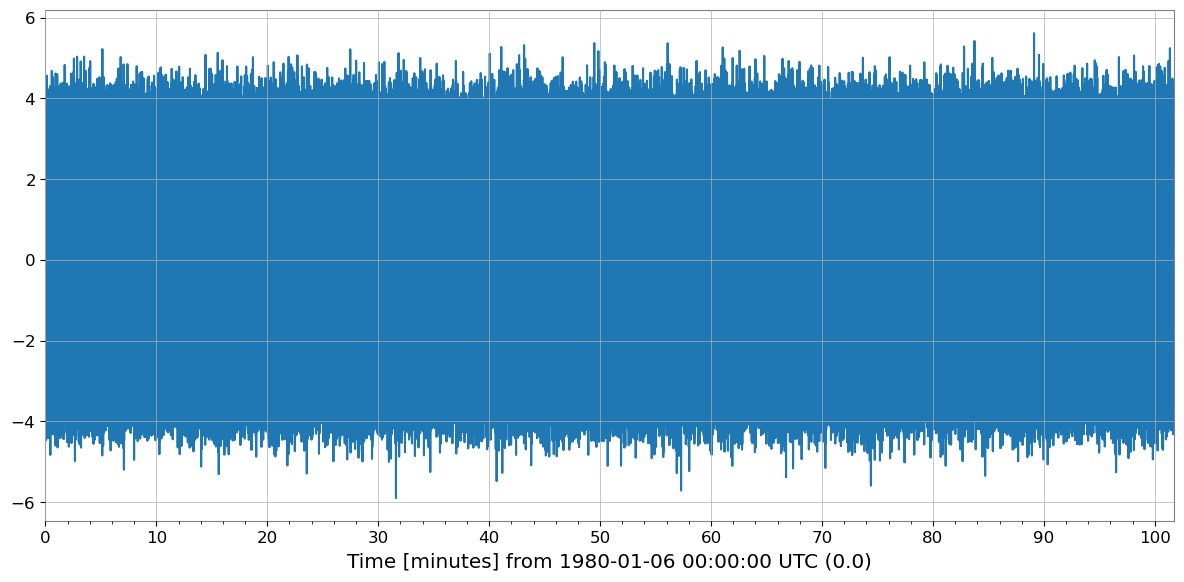

In [6]:
from gwexpy.timeseries import TimeSeries
import numpy as np

# 1,000,00000 サンプルのデータを生成
ts_large = TimeSeries(np.random.randn(100000000), sample_rate=16384, name='Large TS')

print(f'Original samples: {len(ts_large)}')

# プロット実行 (自動的に間引きが行われる)
plot_opt = ts_large.plot()

# 描画された点数を確認
ax = plot_opt.gca()
line = ax.get_lines()[0]
print(f'Plotted points: {len(line.get_xdata())}')
plot_opt.show()

### コレクション・行列への適用とパラメータ指定

`TimeSeriesList` や `TimeSeriesMatrix` でも透過的に機能します。また、閾値を下げて強制的に適用させることも可能です。

Original: 20000, Plotted: 2000


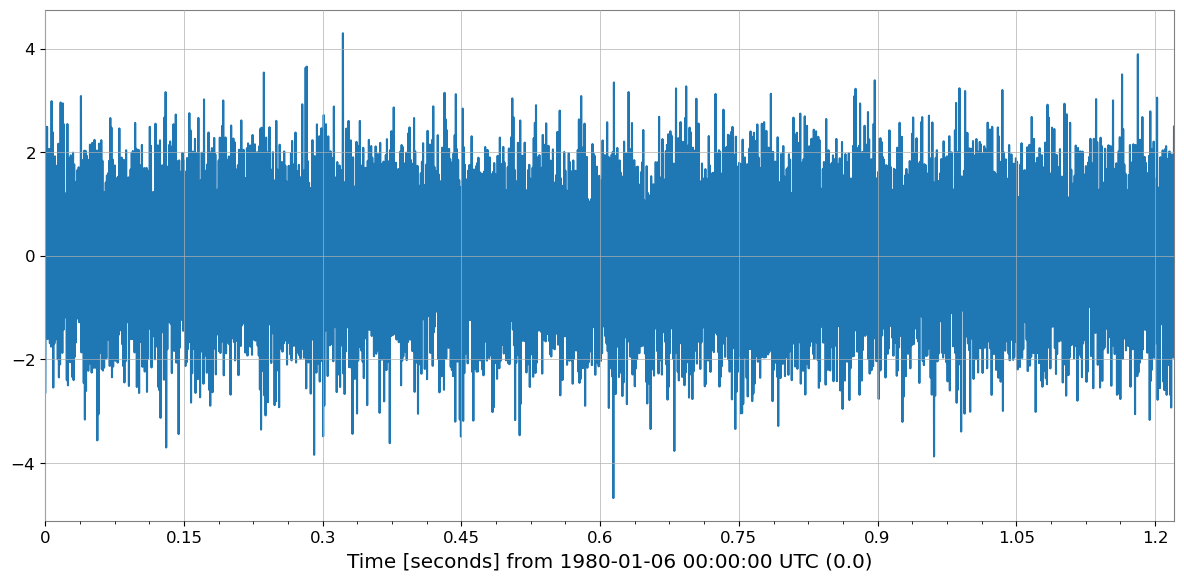

In [7]:
# 閾値を 10,000 に下げて、プロット点数を 2,000 に指定する例
ts_med = TimeSeries(np.random.randn(20000), sample_rate=16384, name='Medium TS')

plot_custom = ts_med.plot(
    decimate_threshold=10000, 
    decimate_points=2000
)

ax = plot_custom.gca()
print(f'Original: {len(ts_med)}, Plotted: {len(ax.get_lines()[0].get_xdata())}')
plot_custom.show()

## 5. Spectrogram Summary Plotting

`plot_summary` は、複数の `Spectrogram` を垂直に並べ、それぞれの右側に `FrequencySeries` の統計量（10%, 50%, 90% パーセンタイル）をプロットする機能です。
スペクトログラムの時間変化と、その全体的な周波数特性を並べて確認する際に非常に便利です。

- **自動同期**: スペクトログラムのカラー軸と FrequencySeries の縦軸が自動的に同期します。
- **MMMプロット**: `plot_mmm` を用いて、Min/Median/Max（または任意のパーセンタイル）を塗りつぶし付きで表示します。

/home/washimi/work/gwexpy/gwexpy/plot/plot.py:597: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


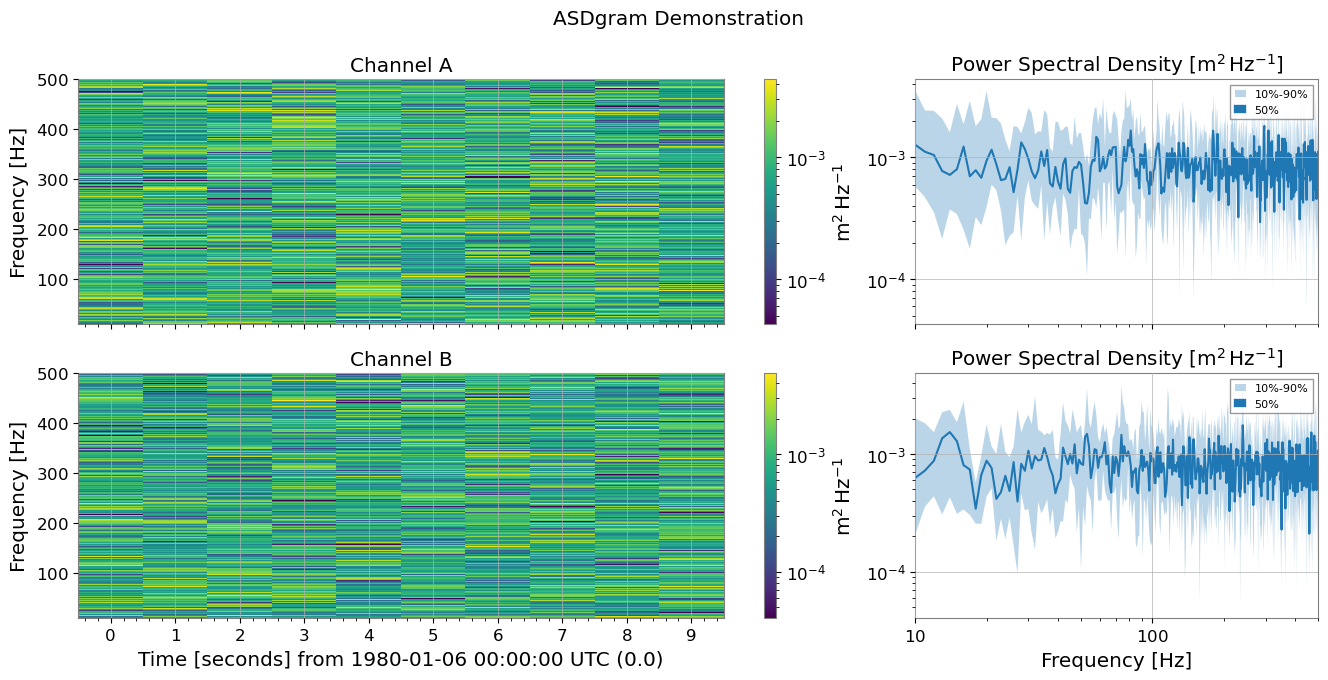

In [8]:
from gwexpy.spectrogram import SpectrogramDict
from gwexpy.timeseries import TimeSeries

# テストデータの生成
def make_sg(name):
    ts = TimeSeries(np.random.randn(2048*10), sample_rate=2048, name=name, unit='m')
    return ts.spectrogram(stride=1, fftlength=1, overlap=0.5)

sg_dict = SpectrogramDict({
    'Channel A': make_sg('A'),
    'Channel B': make_sg('B')
})

# ASDgram プロットの実行
fig, axes = sg_dict.plot_summary(fmin=10, fmax=500, title='ASDgram Demonstration')
plt.show()